In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import matplotlib.colors as mcolors

# CSV 파일 경로와 이미지 폴더 경로
csv_path = '../DeepLab+++.csv'
image_dir = '../test/DCM/'


# CSV 파일 읽기
df = pd.read_csv(csv_path)

# 이미지들~
pngs = {
    os.path.relpath(os.path.join(root, fname), start=image_dir)
    for root, _dirs, files in os.walk(image_dir)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}
pngs = sorted(list(pngs))

In [2]:
height = width = 512
origin_size = 2048
colors = list(mcolors.TABLEAU_COLORS.values())[:29]

def plot_csv(idx, ax):
    # 배경 이미지 불러오기 (1채널 -> RGB -> RGBA -> 크기 조정)
    background = Image.open(os.path.join(image_dir, pngs[idx])).convert("L").resize((width, height))
    background_rgb = Image.merge("RGB", (background, background, background))
    background_rgba = background_rgb.convert("RGBA")
    background_array = np.array(background_rgba, dtype=np.float32) / 255.0

    # 29개의 개별 마스크
    lst = df.values[(idx*29):(idx*29)+29]

    # 복사본으로 겹쳐 그릴 수 있도록 준비
    mask_total = background_array.copy()

    for j in range(len(lst)):
        # RLE 데이터 추출 및 디코딩
        rle_data = list(map(int, lst[j][2].split()))
        mask = np.zeros(origin_size * origin_size, dtype=np.uint8)  # 원본 크기로 디코딩
        for k in range(0, len(rle_data), 2):
            start = rle_data[k]
            length = rle_data[k + 1]
            mask[start:start + length] = 1
        mask = mask.reshape((origin_size, origin_size))
        
        # 마스크를 512x512로 리사이즈
        mask = np.array(Image.fromarray(mask).resize((width, height), Image.NEAREST))
        
        # 마스크 색상 설정
        color = mcolors.to_rgba(colors[j % len(colors)], alpha=0.1)
        color_mask = np.zeros((height, width, 4), dtype=np.float32)
        for c in range(3):  # RGB 채널
            color_mask[:, :, c] = color[c] * mask
        color_mask[:, :, 3] = color[3] * mask  # Alpha 채널
        
        # 총합 마스크에 겹쳐 그리기
        mask_total += color_mask
        
    # 유효 범위로 클리핑 (0~1 사이로 조정)
    mask_total = np.clip(mask_total, 0, 1)

    # 최종 이미지 표시
    ax.imshow(mask_total)
    ax.axis('off')
    ax.set_title(f'{idx} {pngs[idx]}')

In [3]:
idx=156

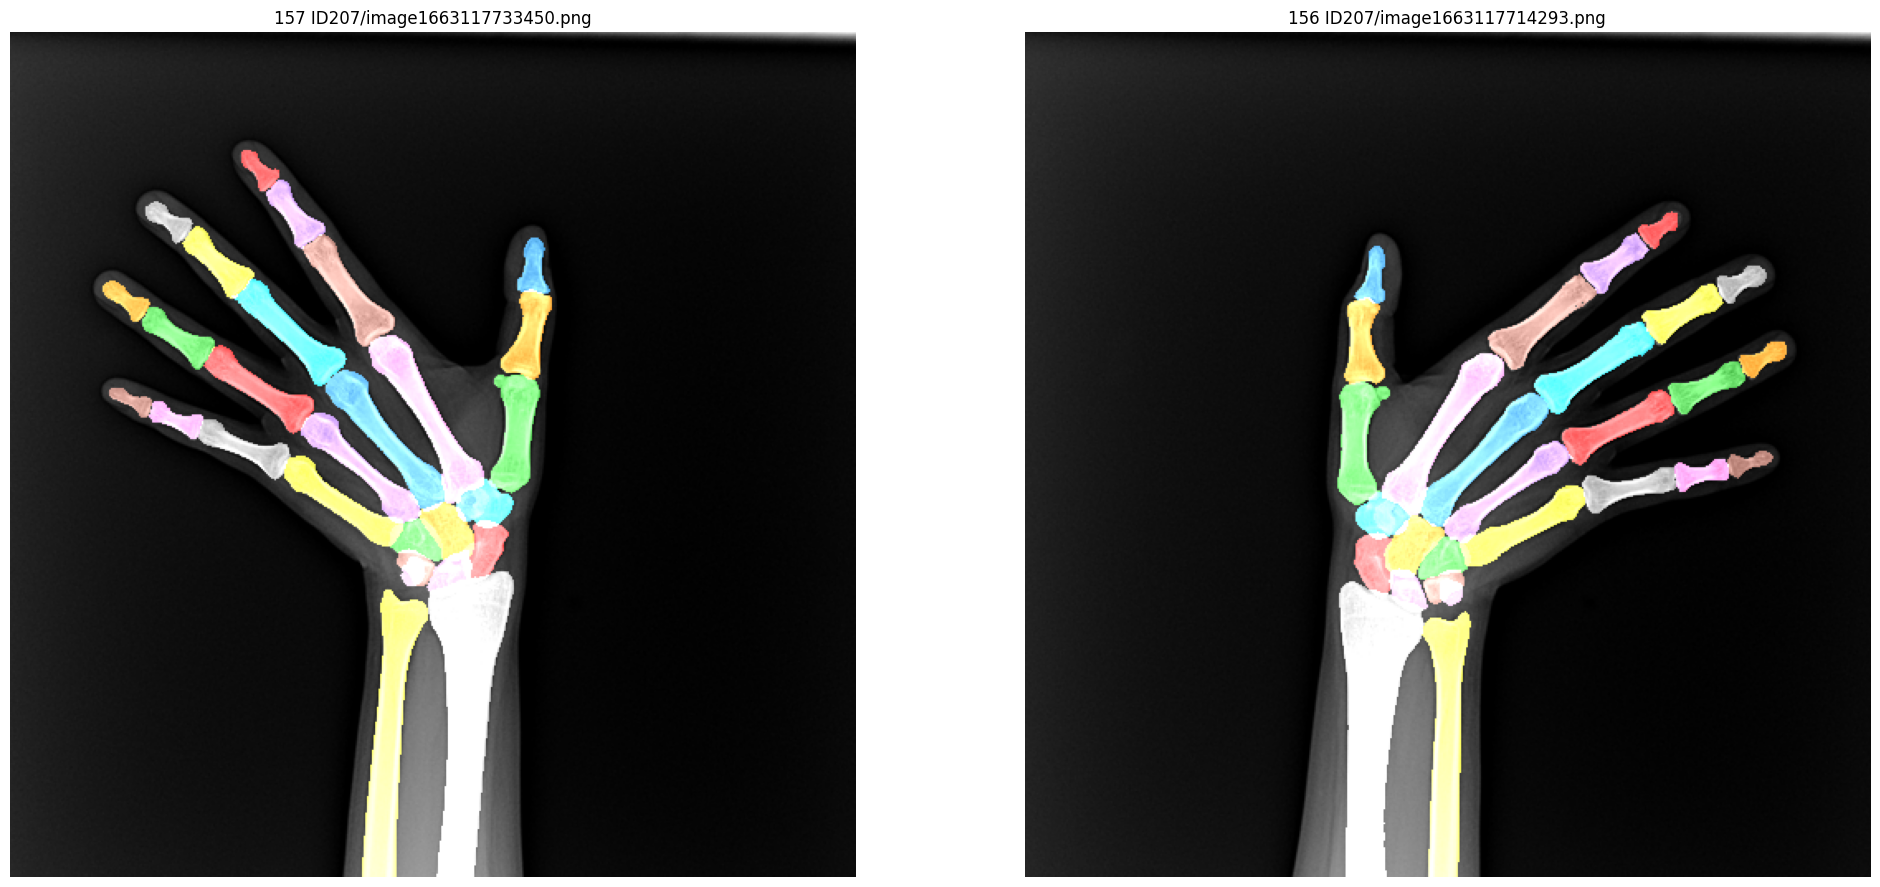

In [4]:
size=12
fig, axes = plt.subplots(1,2,figsize=[size*2,size])
plot_csv(idx, axes[1])
plot_csv(idx+1, axes[0])

idx+=2

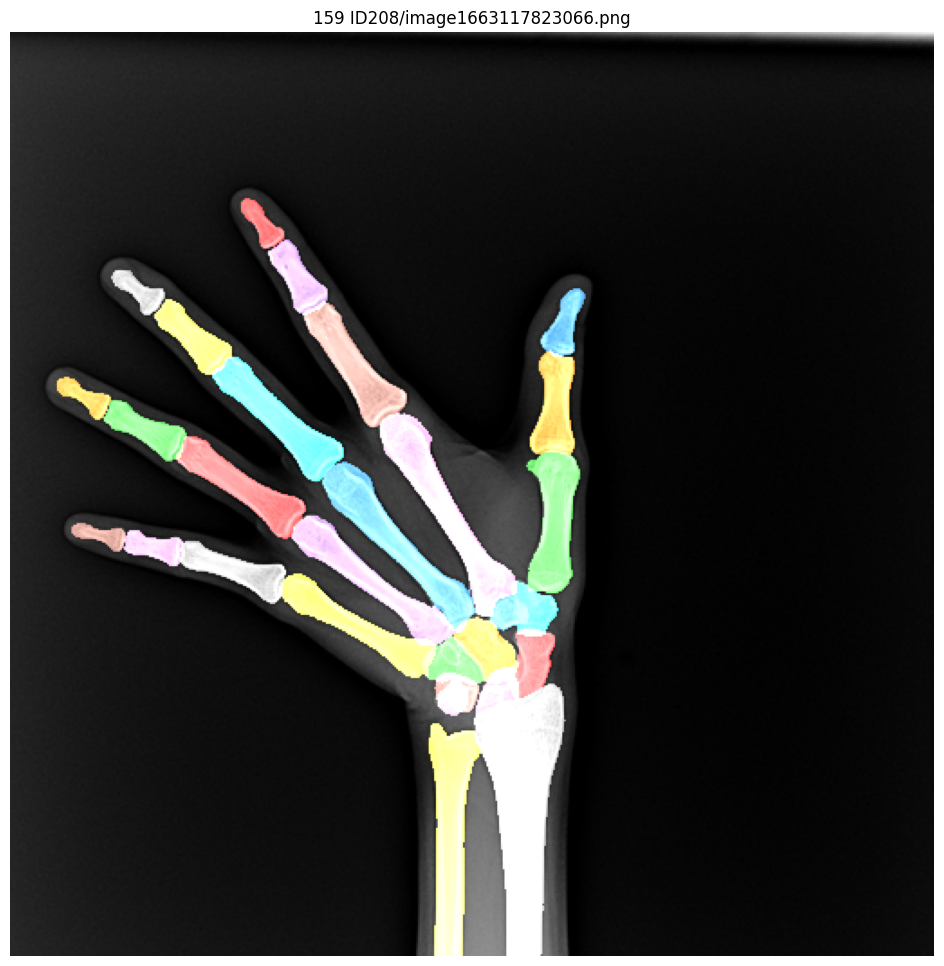

In [6]:
size=12
fig, ax = plt.subplots(1,1,figsize=[size,size])
plot_csv(idx,ax)
idx+=1